In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import os
import sys
from statistics import mean
import pickle

%matplotlib inline
pd.set_option('display.max_colwidth', 200)


def handle_helper_functions():
    print(sys.path)
    directory_path = os.path.abspath(os.path.join('../../helper'))
    if directory_path not in sys.path:
        sys.path.append(directory_path)    

    translation_path=os.path.abspath(os.path.join('../../utils')) 
    if translation_path not in sys.path:
        sys.path.append(translation_path)   
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/test/helper')                                       
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/utils')
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/data')


    lstm_helper_path = os.path.abspath(os.path.join('./create-model/lstm/'))
    if lstm_helper_path not in sys.path:
        sys.path.append(lstm_helper_path)    

    print(sys.path)
    

handle_helper_functions()

['/Users/learn/Desktop/Projects/machine-translation/train/lstm', '/Users/learn/.vscode/extensions/ms-toolsai.jupyter-2022.11.1003412109/pythonFiles', '/Users/learn/.vscode/extensions/ms-toolsai.jupyter-2022.11.1003412109/pythonFiles/lib/python', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python39.zip', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/lib-dynload', '', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9/site-packages']
['/Users/learn/Desktop/Projects/machine-translation/train/lstm', '/Users/learn/.vscode/extensions/ms-toolsai.jupyter-2022.11.1003412109/pythonFiles', '/Users/learn/.vscode/extensions/ms-toolsai.jupyter-2022.11.1003412109/pythonFiles/lib/python', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python39.zip', '/Users/learn/Desktop/Projects/machine-translation/.env/lib/python3.9', '/Users/learn/Desktop/Projects/machine-t

### Importing Path of Helper Functions

In [2]:
from nltk.translate.bleu_score import sentence_bleu
import tensorflow_text as text
from scoreTest import get_cosine_val, get_BLEU_score, get_ROUGE_score
from translate import  translate_sentence
from preprocessing_text import removePunctuation, toLowercase
from iit_dataset import createDataset

Using custom data configuration cfilt--iitb-english-hindi-911387c6837f8b91
Reusing dataset parquet (/Users/learn/.cache/huggingface/datasets/parquet/cfilt--iitb-english-hindi-911387c6837f8b91/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
import warnings
warnings.filterwarnings('ignore')
import string
import re
from unicodedata import normalize
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [4]:
data_size=15000

pool_oftexts, pairs =createDataset(data_size=data_size, type="train")
dataset= pool_oftexts

In [5]:
# How many sentences will be used
# Limit the sentences to 10.000 on Kaggle to avoid exceding the
# available RAM space
# Build a generator to avoid this issue

total_sentences = 5000

# Load the dataset

# What proportion of the sentences will be used for the test set
test_proportion = 0.1
train_test_threshold = int( (1-test_proportion) * total_sentences)

printmd(f'## {total_sentences} "parallel sentences" will be loaded (original sentence + its translation)')
printmd(f'## {train_test_threshold} "parallel sentences" will be used to train the model')
printmd(f'## {total_sentences-train_test_threshold} "parallel sentences" will be used to test the model')

## 5000 "parallel sentences" will be loaded (original sentence + its translation)

## 4500 "parallel sentences" will be used to train the model

## 500 "parallel sentences" will be used to test the model

Source and Target Index

In [6]:
idx_src=0
idx_tar = 1

In [7]:
# Shuffle the dataset
dataset = dataset.sample(frac=1, random_state=0)
dataset.iloc[1000:1010]

,hindi,eng
2395,बेकर्स खेल,bakers game
7095,त्रुटि,error
280,नाम,name
14696,विजेट नहीं मिलाः s,widget not found s
6487,छैतिज पैमाना,editor text transformation
11028,सभी खण्डन बिन्दु अक्षम करें,disable all breakpoints
2994,नियंत्रण की शैली का चयन करें,select the style of control
4624,टूटते तारे,falling stars
11901,जोड़ें समूह,cannot add group
1018,मान,value


In [8]:
def clean(string):
    # Clean the string
    string = string.replace("\u202f"," ") # Replace no-break space with space
    string = string.lower()
    
    # Delete the punctuation and the numbers
    for p in punctuation + "«»" + "0123456789":
        string = string.replace(p," ")
        
    string = re.sub('\s+',' ', string)
    string = string.strip()
           
    return string

# Clean the sentences
dataset["eng"] = dataset["eng"].apply(lambda x: clean(x))
dataset["hindi"] = dataset["hindi"].apply(lambda x: clean(x))

# Select one part of the dataset
dataset = dataset.values
dataset = dataset[:total_sentences]

# split into train/test
train, test = dataset[:train_test_threshold], dataset[train_test_threshold:]

# Define the name of the source and of the target
# This will be used in the outputs of this notebook
source_str, target_str = "Hindi", "English"

# The index in the numpy array of the source and of the target


In [9]:
pd.DataFrame(dataset[1000:1010])


,0,1
0,बेकर्स खेल,bakers game
1,त्रुटि,error
2,नाम,name
3,विजेट नहीं मिलाः s,widget not found s
4,छैतिज पैमाना,editor text transformation
5,सभी खण्डन बिन्दु अक्षम करें,disable all breakpoints
6,नियंत्रण की शैली का चयन करें,select the style of control
7,टूटते तारे,falling stars
8,जोड़ें समूह,cannot add group
9,मान,value


In [10]:
def create_tokenizer(lines):
    # fit a tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 

def encode_sequences(tokenizer, length, lines):
    # encode and pad sequences
    X = tokenizer.texts_to_sequences(lines) # integer encode sequences
    X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
    return X
 
def encode_output(sequences, vocab_size):
    # one hot encode target sequence
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
 
# Prepare target tokenizer
tar_tokenizer = create_tokenizer(dataset[:, idx_tar]) #save
tar_vocab_size = len(tar_tokenizer.word_index) + 1  #save
tar_length = 15  #save
printmd(f'\nTarget ({target_str}) Vocabulary Size: {tar_vocab_size}')
printmd(f'Target ({target_str}) Max Length: {tar_length}')

# Prepare source tokenizer
src_tokenizer = create_tokenizer(dataset[:, idx_src])  #save
src_vocab_size = len(src_tokenizer.word_index) + 1  #save
src_length = 15  #save
printmd(f'\nSource ({source_str}) Vocabulary Size: {src_vocab_size}')
printmd(f'Source ({source_str}) Max Length: {src_length}\n')
 
# Prepare training data
trainX = encode_sequences(src_tokenizer, src_length, train[:, idx_src])
trainY = encode_sequences(tar_tokenizer, tar_length, train[:, idx_tar])
trainY = encode_output(trainY, tar_vocab_size)

# Prepare test data
testX = encode_sequences(src_tokenizer, src_length, test[:, idx_src])
testY = encode_sequences(tar_tokenizer, tar_length, test[:, idx_tar])
testY = encode_output(testY, tar_vocab_size)


Target (English) Vocabulary Size: 1696

Target (English) Max Length: 15


Source (Hindi) Vocabulary Size: 2032

Source (Hindi) Max Length: 15


Epoch 1/200


2023-01-21 23:25:44.486417: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


64/64 [==============================] - 8s 90ms/step - loss: 2.9562 - val_loss: 1.7104
Epoch 2/200
64/64 [==============================] - 5s 82ms/step - loss: 1.6455 - val_loss: 1.5779
Epoch 3/200
64/64 [==============================] - 6s 91ms/step - loss: 1.5568 - val_loss: 1.5928
Epoch 4/200
64/64 [==============================] - 6s 91ms/step - loss: 1.5808 - val_loss: 1.7649
Epoch 5/200
64/64 [==============================] - 6s 95ms/step - loss: 1.6033 - val_loss: 1.7215
Epoch 6/200
64/64 [==============================] - 6s 94ms/step - loss: 1.5819 - val_loss: 1.7251
Epoch 7/200
64/64 [==============================] - 6s 90ms/step - loss: 1.5592 - val_loss: 1.6827
Epoch 8/200
64/64 [==============================] - 6s 90ms/step - loss: 1.5199 - val_loss: 1.6294
Epoch 9/200
64/64 [==============================] - 6s 88ms/step - loss: 1.4704 - val_loss: 1.5709
Epoch 10/200
64/64 [==============================] - 5s 84ms/step - loss: 1.4402 - val_loss: 1.5499
Epoch 11/20

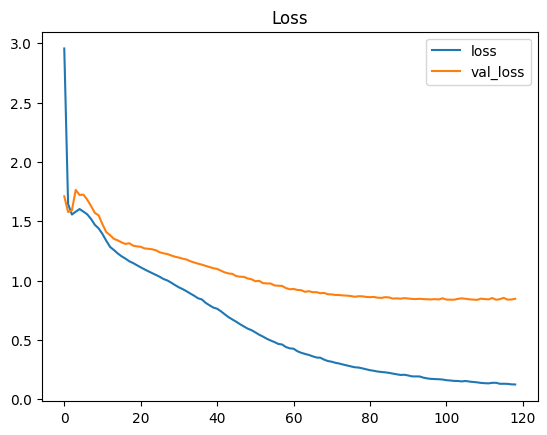

In [11]:
def create_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    # Create the model
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model
 
# Create model
model = create_model(src_vocab_size, tar_vocab_size, src_length, tar_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

history = model.fit(trainX, 
          trainY, 
          epochs=200,#200 
          batch_size=64, 
          validation_split=0.1, 
          verbose=1,
          callbacks=[
                        EarlyStopping(
                        monitor='val_loss',
                        patience=10,
                        restore_best_weights=True
                    )
            ])


model.summary()
# save model in computer '/Users/learn/Desktop/Projects/machine-translation/data'
# model.save()
pd.DataFrame(history.history).plot()
plt.title("Loss")
plt.show()

### Load Previously Saved Model

In [12]:
# from tensorflow import keras
# model = keras.models.load_model('lstm_model')
# model.summary()

In [13]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)
    
def create_dataframe_to_score(model, tokenizer, sources, raw_dataset):
    # Get the bleu score of a model
    actual, predicted, actual_rouge , cosine_value_list= [], [],[], []
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_src, raw_target = raw_dataset[i]
        actual.append([raw_target.split()])
        actual_rouge.append(raw_target.split())
        predicted.append(translation.split())
        #######################################################################
                    ####   Calculate Cosine Value   ####

        cosine_value= get_cosine_val (translation,raw_target )
        cosine_value_list.append(cosine_value)
        #######################################################################
        # print("predicted ",translation.split())    
   
    average_cosine= mean(cosine_value_list)
    return actual, predicted, actual_rouge, average_cosine

actual, predicted, actual_rouge, average_cosine =create_dataframe_to_score(model, tar_tokenizer, testX, test)

In [14]:
def bleu_score(actual, predicted):
    # Get the bleu score of a model
    bleu_dic = {}
    bleu_dic['bleu-1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['bleu-1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['bleu-1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['bleu-1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_dic

def calculate_ROUGE(actual, predicted):
    hypotheses = tf.ragged.constant(predicted)
    references = tf.ragged.constant(actual)

    rouge_test= text.metrics.rouge_l(hypotheses, references)
    f_measure_list= rouge_test.f_measure
    p_measure_list= rouge_test.p_measure
    r_measure_list= rouge_test.r_measure
  

    f_measure_average= (f_measure_list.numpy()).mean()
    p_measure_average= (p_measure_list.numpy()).mean()
    r_measure_average=(r_measure_list.numpy()).mean()
    return { "f_measure_average":f_measure_average, "p_measure_average":p_measure_average, "r_measure_average":r_measure_average  }  




In [15]:
# result= get_cosine_val (actual[0], predicted[0])

# result= get_cosine_val ("I love cow","i love grass" )
# result

actual[0]

[['starter']]

In [16]:
predicted[0]

['started']

In [17]:
# Compute the BLEU Score
# bleu_train = bleu_score(model, tar_tokenizer, trainX, train)
bleu_test = bleu_score(actual, predicted)
rouge_test = calculate_ROUGE(actual=actual_rouge, predicted=predicted)

In [18]:
print(rouge_test)
print(bleu_test)
print(average_cosine)

{'f_measure_average': 0.6280448, 'p_measure_average': 0.6425304, 'r_measure_average': 0.6244826}
{'bleu-1-grams': 0.5761875971001981, 'bleu-1-2-grams': 0.47235718946621513, 'bleu-1-3-grams': 0.4180643700339435, 'bleu-1-4-grams': 0.31438295639571906}
0.6457518530382219


In [19]:
# plt.bar(x = bleu_train.keys(), height = bleu_train.values())
# plt.title("BLEU Score with the training set")
# plt.ylim((0,1))
# plt.show()

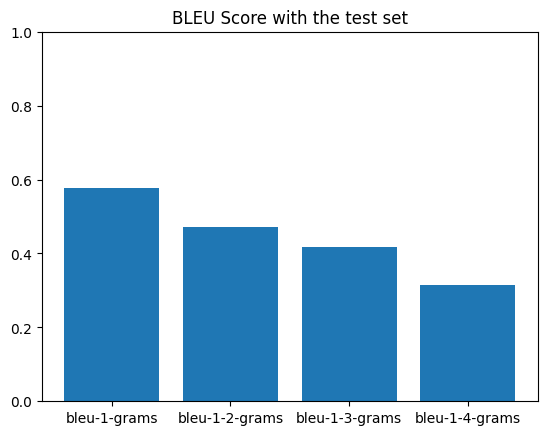

In [20]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.show()

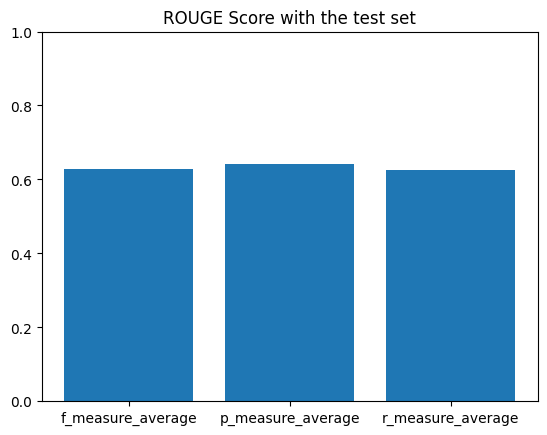

In [21]:
plt.bar(x = rouge_test.keys(), height = rouge_test.values())
plt.title("ROUGE Score with the test set")
plt.ylim((0,1))
plt.show()

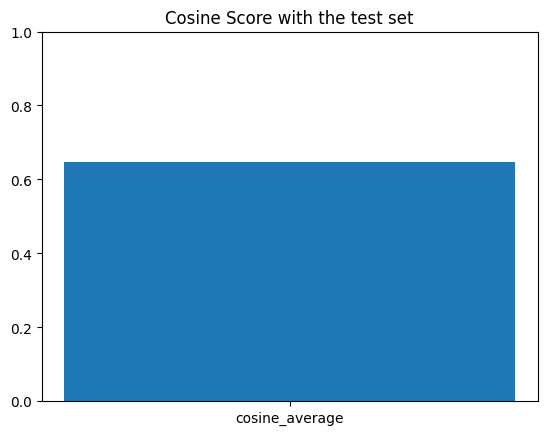

In [22]:
plt.bar(x = "cosine_average", height = average_cosine)
plt.title("Cosine Score with the test set")
plt.ylim((0,1))
plt.show()

In [23]:
keys=["Dataset Size", *rouge_test.keys(), "cosine_similarity", *bleu_test.keys()]

values=[total_sentences,  *rouge_test.values(), average_cosine, *bleu_test.values() ]

table =pd.DataFrame(columns=keys, data=[values])
table


,Dataset Size,f_measure_average,p_measure_average,r_measure_average,cosine_similarity,bleu-1-grams,bleu-1-2-grams,bleu-1-3-grams,bleu-1-4-grams
0,5000,0.628045,0.64253,0.624483,0.645752,0.576188,0.472357,0.418064,0.314383


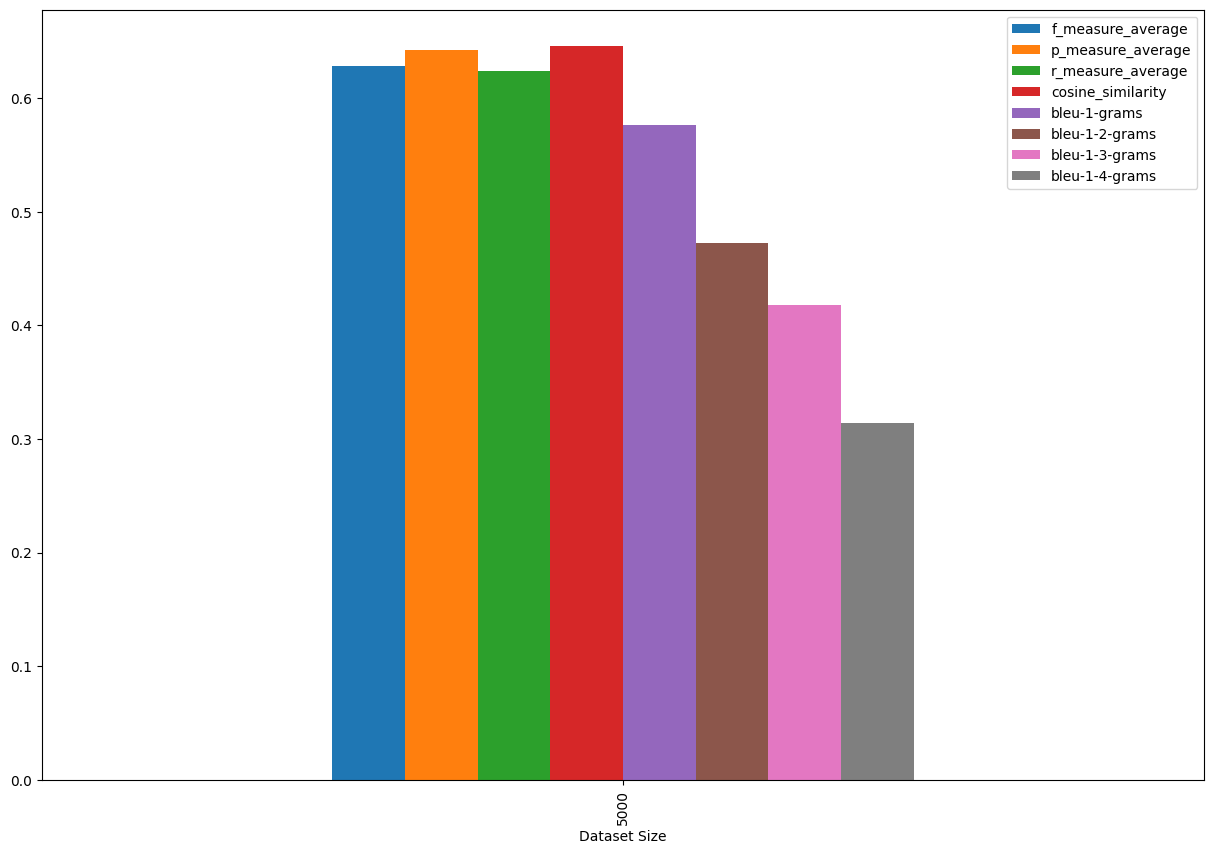

In [24]:
import matplotlib.pyplot as plot
from matplotlib.ticker import ScalarFormatter
#,figsize=(10,15)

table.plot.bar(x="Dataset Size",figsize=(15,10))
plot.show(block=True)


###  Save Model and Parameters

In [25]:
import json
import os

def saveAnalytics(analytics_table):
 

    fname = "../../analytics/lstm/"+"analytics.json"

    if os.path.exists(fname):
        # read existing file and append new data
        with open(fname,"r") as f:
            df = pd.read_json(fname)
            new_data=(analytics_table.to_numpy())[0] 
            df.loc[len(df.index)] = new_data # add another row
            print("Update ",df.to_numpy() )
            df.to_json(r'../../analytics/lstm/'+"analytics.json",orient='records')
    else:
        # create new json
        print("Create ",analytics_table )
        analytics_table.to_json(r'../../analytics/lstm/'+"analytics.json",orient='records')


def save_models_and_parameters(total_sentences,model,src_tokenizer, tar_tokenizer, src_length, tar_length, src_vocab_size,tar_vocab_size, analytics_table ):
    model_name = str(total_sentences)
    path="../../model/lstm/"+model_name+"/"
    
    src_parameters={
        'src_length': src_length,
        'src_vocab_size': src_vocab_size,
    }
    src_tokenizer= src_tokenizer

    target_parameters={
        'target_length': tar_length,
        'target_vocab_size': tar_vocab_size,
    }
    target_tokenizer= tar_tokenizer

    model.save(path+'lstm_model' ) 
    with open(path+'src_parameters.pickle', 'wb') as handle:
        pickle.dump(src_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(path+'src_tokenizer.pickle', 'wb') as handle:
        pickle.dump(src_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(path+'target_parameters.pickle', 'wb') as handle:
        pickle.dump(target_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(path+'target_tokenizer.pickle', 'wb') as handle:
        pickle.dump(target_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    saveAnalytics(analytics_table=analytics_table)
   

   
save_models_and_parameters(total_sentences,model,src_tokenizer, tar_tokenizer, src_length, tar_length, src_vocab_size,tar_vocab_size, table )



2023-01-21 23:37:53.932260: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../model/lstm/5000/lstm_model/assets


INFO:tensorflow:Assets written to: ../../model/lstm/5000/lstm_model/assets


Update  [[1.00000000e+004 7.64712036e-001 7.75633931e-001 7.64969170e-001
  7.86634681e-001 7.47674297e-001 6.53796439e-001 5.93642770e-001
  4.87186522e-001]
 [1.00000000e+003 2.93089580e-002 5.75000010e-002 2.00046729e-002
  5.06093138e-002 7.78850730e-003 3.61603232e-156 9.77707822e-187
  7.79150476e-233]
 [5.00000000e+003 6.28044784e-001 6.42530382e-001 6.24482572e-001
  6.45751853e-001 5.76187597e-001 4.72357189e-001 4.18064370e-001
  3.14382956e-001]]
